## **Checkpoint-5**

In [2]:
# Install necessary packages 
!pip install psycopg2-binary

# Import necessary packages
import pandas as pd
import psycopg2

     |████████████████████████████████| 3.0MB 12.5MB/s 
ERROR: Operation cancelled by user


/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
# Connect to the database using psycopg2

db_host = "cpdb.cgod7egsd6vr.us-east-2.rds.amazonaws.com"
db_user = "cpdb-student"
db_password = "dataSci4lyf"
db_name = "cpdb"

connection = psycopg2.connect(host = db_host,  
                              user = db_user, 
                              password = db_password, 
                              dbname = db_name)

connection

<connection object at 0x7f1b4fe73638; dsn: 'user=cpdb-student password=xxx dbname=cpdb host=cpdb.cgod7egsd6vr.us-east-2.rds.amazonaws.com', closed: 0>

In [4]:
# Query the database for text summaries for the complaints and store them in a dataframe
sql_query = "SELECT crid as cr_id, summary FROM data_allegation where summary > '';"
cpdb_nar_df = pd.read_sql(sql_query, con=connection)
# Replace all null summaries with empty strings
cpdb_nar_df.summary.fillna('', inplace=True)
cpdb_nar_df

cr_id                                            summary
0     1000214  On October 4, 2006, a complaint was registered...
1     1002796  On 18 January 2007, a complaint was registered...
2     1003786  On March 2, 2007, a complaint was registered w...
3     1006073  On May 28, 2007, a complaint was registered wi...
4     1016377  In an incident involving an off on-duty CPD Of...
...       ...                                                ...
1142  1075421  At approximately 3:41 am. on May 30, 2015, was...
1143  1085782  On July 1, 2017, at approximately 10:50 pm. Of...
1144  1078989  According to Civilian 12 on January 21, 2016, ...
1145  1049286  On the above date and time, _was the front sea...
1146  1082565  After being out at Pub, the complainant, took ...

[1147 rows x 2 columns]

In [7]:
from google.colab import drive
drive.mount('/content/drive')

!cp drive/My\ Drive/narratives.csv .

## **Import the dataset and data cleaning**

In [ ]:
nar_df = pd.read_csv(r'narratives.csv',
                     usecols=['cr_id', 'column_name', 'text'],
                     dtype={"cr_id": "string", "column_name": "string", "text": "string"})

# Remove rows where 'column_name' is not in {'Initial / Intake Allegation', 'Allegation'}
nar_df = nar_df[nar_df['column_name'].isin(['Initial / Intake Allegation', 'Allegation'])]
# Set to text to '' where text = {'(None entered)', 'NO AFFIDAVIT'}
nar_df['text'] = nar_df['text'].replace(['(None entered)', 'NO AFFIDAVIT'], '')
# Remove rows where 'column_name' is not in {'Initial / Intake Allegation', 'Allegation'}
nar_df = nar_df[nar_df['column_name'].isin(['Initial / Intake Allegation', 'Allegation'])]
# Set to text to '' where text = {'(None entered)', 'NO AFFIDAVIT'}
nar_df['text'] = nar_df['text'].replace(['(None entered)', 'NO AFFIDAVIT'], '')
# Replace carriage returns in text with spaces
nar_df['text'] = nar_df['text'].str.replace('\\n', ' ')
nar_df['text'] = nar_df['text'].str.replace('\\r', ' ')

# Trim whitespace from head and tail of the text
nar_df['text'] = nar_df['text'].str.strip()
# Remove rows where there is no value in the text column
nar_df = nar_df[nar_df['text'] != '']
# Remove duplicate summaries for a single allegation id (heuristic: take the one with the longer narrative text)
nar_df = nar_df.sort_values('text').drop_duplicates('cr_id', keep='last')
nar_df = nar_df.sort_values('cr_id')
# Pull out the needed columns and rename them to align with the allegation_df
subset_nar_df = nar_df[['cr_id', 'text']]
subset_nar_df =  subset_nar_df.rename(columns={"cr_id": "cr_id", "text": "summary"})
# Concatenate the two datasets
final_df = pd.concat([cpdb_nar_df, subset_nar_df], ignore_index=True)
# Remove duplicate summaries for a single allegation id (heuristic: take the one with the longer narrative text)
final_df = final_df.sort_values('summary').drop_duplicates('cr_id', keep='last')
final_df = final_df.sort_values('cr_id')

# Remove rows where there is no value in the summary column
final_df = final_df[final_df['summary'] != '']
final_df.reset_index()

final_df

cr_id                                            summary
3     1000214  On October 4, 2006, a complaint was registered...
461   1000301  On October 8, 2006, a complaint was registered...
599   1000854  On October 29, 2006, a complaint was registere...
51    1000936  On 01 November 2006, a complaint was registere...
465   1001233  On November 12, 2006, a complaint was register...
...       ...                                                ...
434    314738  On August 6, 2006, a complaint was registered ...
435    315128  On August 2005, a complaint was registered wit...
579    315271  On 02 September 2006, a complaint was register...
691    315303  On 04 September 2006, a complaint was register...
1114   315420  On 11 September 2006, a complaint was register...

[16010 rows x 2 columns]

## **Data integration with race information**

In [ ]:
sql_query = \
"SELECT DISTINCT a.allegation_id as cr_id, \
           data_complainant.race as complainant_race \
    FROM data_officerallegation as a \
             INNER JOIN data_complainant \
                             ON a.allegation_id = data_complainant.allegation_id;"

# Execute this query and get the results
complaint_df = pd.read_sql(sql_query, con=connection)

# Close the connection to the database
connection.close()

complaint_df

cr_id        complainant_race
0      1000002                Hispanic
1      1000004                Hispanic
2      1000006                   Black
3      1000007                   White
4      1000009                Hispanic
...        ...                     ...
36620  1089977                   Black
36621  1089977                   White
36622  1089998                   Black
36623  1089998                   White
36624  1090030  Asian/Pacific Islander

[36625 rows x 2 columns]

In [ ]:
# Join the queried complaint data to the existing set of cleaned and integrated narratives
all_narratives_df = pd.merge(final_df, complaint_df, on='cr_id')

all_narratives_df

cr_id  ...        complainant_race
0     1000214  ...                   Black
1     1000301  ...                   Black
2     1000854  ...                Hispanic
3     1000936  ...                   Black
4     1000936  ...                Hispanic
...       ...  ...                     ...
6442  1089285  ...                   Black
6443  1089294  ...                   Black
6444  1089320  ...                   Black
6445  1089369  ...                   Black
6446  1090030  ...  Asian/Pacific Islander

[6447 rows x 3 columns]

Group the races

In [ ]:
all_narratives_df.complainant_race.value_counts()

Black                             3667
White                             1541
Hispanic                           704
                                   462
Asian/Pacific Islander              60
Native American/Alaskan Native      13
Name: complainant_race, dtype: int64

## **Using NLTK**

In [ ]:
from nltk import *
# This will let us filter punctuation and common keywords (i.e. stopwords)
download('popular')

# This will allow us to tag tokens in our texts in different ways, including by part of speech
download('tagsets')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

True

In [ ]:
from scipy import special
from nltk import *
from nltk.corpus import stopwords

## **All races together**

In [ ]:
summary_black = []
for i in range(len(all_narratives_df)):
  if i == 0:
    All = '0, '
  # if all_narratives_df['complainant_race'][i] == "White":
  All = All + all_narratives_df['summary'][i]

tokens = word_tokenize(All)

notalpha = [ token for token in tokens if not token.isalpha() ]
freqs = FreqDist(notalpha)
print( freqs.most_common(100) )

tokens_clean = [ token for token in tokens if token.isalpha() ]

# print(tokens_clean)

[(',', 20239), ('.', 12265), (';', 2831), ('(', 2414), (')', 2305), ('``', 1675), ('?', 1378), ('1', 1369), ("''", 1369), ('#', 1219), ("'s", 1060), ('“', 695), ('”', 628), (':', 534), ('-', 489), ('$', 451), ('on-duty', 433), ('911', 427), ('2012', 424), ('2', 363), ('off-duty', 362), ('2009', 360), ('2011', 348), ('|', 269), ('2008', 257), ('2013', 247), ("n't", 244), ('&', 232), ('party/victim', 232), ('‘', 219), ('2007', 205), ('2010', 185), ('Mr.', 182), ('15', 175), ('30', 165), ('2014', 164), ('10', 159), ('P.O', 159), ('12', 158), ('2017', 157), ('13', 154), ('and/or', 152), ('5', 151), ('3', 144), ("'S", 134), ('_and', 133), ('!', 132), ('4', 131), ('S.', 131), ('20', 125), ('justification.The', 119), ('14', 116), ("'re", 116), ("'m", 109), ('21', 102), ('6', 97), ('11', 97), ('29', 95), ('17', 95), ('2015', 94), ('16', 91), ('26', 90), ('’', 87), ('23', 86), ('18', 83), ('28', 80), ('19', 79), ('Ms.', 79), ('22', 78), ('2016', 78), ('9', 76), ('1s', 76), ('7', 75), ('25', 73)

In [ ]:
# Use another list comprehension to save the lowercase version to tokens_clean (overwriting the original)
tokens_clean = [ token.lower() for token in tokens_clean ]

# Print the result
# print( tokens_clean )

In [ ]:
# This line specifies the size of the figure as out Jupyter Notebook will print it
import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams["figure.figsize"] = [16,7]

# Calculate the frequency for each token from the book and save it to the variable 'frequencies'
frequencies = FreqDist( tokens_clean )

# Call 'frequencies' with the method 'plot' to generate a frequency plot of the 50 most frequent words
# all_plot = frequencies.plot( 100 )

# The line above saves the plot to the variable 'walden_plot'. This line outputs it, so it will appear below.
# walden_plot

# Also print the raw list
# frequencies.most_common(50)

remove stop words

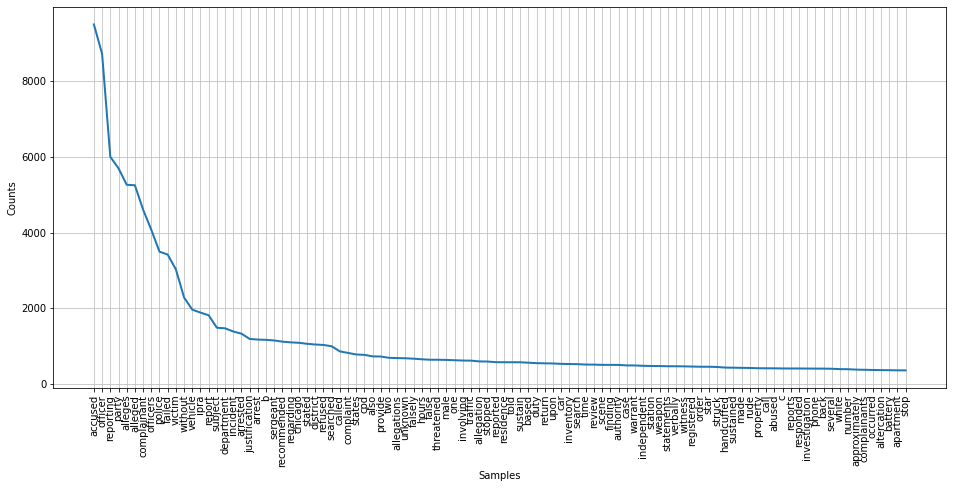

[('accused', 9497),
 ('officer', 8718),
 ('reporting', 6001),
 ('party', 5697),
 ('alleges', 5263),
 ('alleged', 5249),
 ('complainant', 4606),
 ('officers', 4073),
 ('police', 3494),
 ('failed', 3419),
 ('victim', 3026),
 ('without', 2283),
 ('vehicle', 1963),
 ('ipra', 1885),
 ('report', 1815),
 ('subject', 1485),
 ('department', 1470),
 ('incident', 1386),
 ('arrested', 1329),
 ('justification', 1189),
 ('arrest', 1173),
 ('b', 1166),
 ('sergeant', 1149),
 ('recommended', 1118),
 ('regarding', 1099),
 ('chicago', 1088),
 ('stated', 1061),
 ('district', 1042),
 ('refused', 1031),
 ('searched', 996),
 ('called', 861),
 ('complaint', 820),
 ('states', 779),
 ('cpd', 769),
 ('also', 729),
 ('provide', 725),
 ('two', 691),
 ('allegations', 684),
 ('unknown', 679),
 ('falsely', 668),
 ('hours', 652),
 ('false', 640),
 ('threatened', 640),
 ('male', 635),
 ('one', 627),
 ('involving', 619),
 ('traffic', 616),
 ('allegation', 596),
 ('stopped', 593),
 ('reported', 576),
 ('residence', 574),

In [ ]:
######################
## Remove stopwords ##
######################

# Bigger figure
plt.rcParams["figure.figsize"] = [16,7]

# Check every token in 'tokens_clean' against the NLTK stopword list
# Only keep tokens NOT in the list
tokens_clean = [t for t in tokens_clean if not t in set(stopwords.words('english'))]

# Generate a new frequency distribution plot with the 50 most frequent words remaining after filtering
# This follows the same steps as before: We count the frequency of each token, we generate a plot of the top 50, and then we display them.
frequencies = FreqDist( tokens_clean )

# Make plot with top 50 tokens
all_plot = frequencies.plot( 100 )

# Show the plot
all_plot

# Also print the raw list
frequencies.most_common(100)

In [ ]:
All_list = []
for i in range(100):
  word = frequencies.most_common(100)[i][0]
  All_list.append(word)
print(All_list)

['accused', 'officer', 'reporting', 'party', 'alleges', 'alleged', 'complainant', 'officers', 'police', 'failed', 'victim', 'without', 'vehicle', 'ipra', 'report', 'subject', 'department', 'incident', 'arrested', 'justification', 'arrest', 'b', 'sergeant', 'recommended', 'regarding', 'chicago', 'stated', 'district', 'refused', 'searched', 'called', 'complaint', 'states', 'cpd', 'also', 'provide', 'two', 'allegations', 'unknown', 'falsely', 'hours', 'false', 'threatened', 'male', 'one', 'involving', 'traffic', 'allegation', 'stopped', 'reported', 'residence', 'told', 'sustain', 'based', 'duty', 'return', 'upon', 'car', 'inventory', 'search', 'time', 'review', 'scene', 'finding', 'authority', 'case', 'warrant', 'independent', 'station', 'weapon', 'statements', 'verbally', 'witness', 'registered', 'order', 'star', 'struck', 'handcuffed', 'sustained', 'made', 'rude', 'property', 'call', 'abused', 'c', 'reports', 'responded', 'investigation', 'phone', 'back', 'several', 'white', 'number', '

## **Black race**

In [ ]:
summary_black = []
for i in range(len(all_narratives_df)):
  if all_narratives_df['complainant_race'][i] == "Black":
    if i == 0:
      black = all_narratives_df['summary'][i]
    black = black + all_narratives_df['summary'][i]


In [ ]:
tokens = word_tokenize(black)

In [ ]:
notalpha = [ token for token in tokens if not token.isalpha() ]
freqs = FreqDist(notalpha)
print( freqs.most_common(100) )

[(',', 10797), ('.', 6859), (';', 1382), ('(', 1144), ('``', 1086), (')', 1064), ("''", 893), ('?', 874), ('1', 814), ("'s", 597), ('#', 442), ('“', 425), ('”', 407), ('-', 366), (':', 306), ('911', 273), ('$', 241), ('2', 207), ('on-duty', 203), ('|', 185), ("n't", 162), ('2012', 159), ('party/victim', 149), ('2009', 145), ('&', 131), ('off-duty', 129), ('2013', 117), ('‘', 111), ('2008', 108), ('Mr.', 105), ('2017', 100), ('justification.The', 97), ('2011', 96), ('15', 93), ('_and', 93), ('5', 92), ('!', 87), ('2014', 87), ('and/or', 84), ('4', 82), ("'S", 82), ("'re", 79), ('2010', 77), ('10', 76), ("'m", 76), ('13', 75), ('3', 74), ('S.', 70), ('2007', 69), ('30', 63), ('14', 59), ('12', 58), ('him.The', 57), ('11', 53), ('2016', 53), ('2015', 53), ('29', 52), ('20', 51), ('6', 50), ('_was', 50), ('’', 49), ('P.O', 49), ('7', 46), ('8', 45), ('16', 44), ('1s', 44), ('23', 43), ('26', 41), ('Ms.', 40), ('28', 39), ('21', 38), ('her.The', 38), ('25', 36), ('18', 35), ('9', 35), ('W.'

In [ ]:
tokens_clean = [ token for token in tokens if token.isalpha() ]

print(tokens_clean)

['On', 'October', 'a', 'complaint', 'was', 'registered', 'with', 'the', 'Independent', 'Police', 'Review', 'Authority', 'IPRA', 'The', 'Office', 'of', 'Professional', 'Standards', 'regarding', 'an', 'incident', 'occurring', 'in', 'the', 'District', 'on', 'October', 'involving', 'five', 'Chicago', 'Police', 'Department', 'CPD', 'officers', 'Officers', 'A', 'B', 'C', 'D', 'and', 'E', 'and', 'one', 'CPD', 'commander', 'Commander', 'F', 'It', 'was', 'alleged', 'that', 'Officer', 'A', 'who', 'was', 'directed', 'profanity', 'at', 'the', 'complainant', 'and', 'his', 'son', 'pointed', 'a', 'weapon', 'at', 'the', 'complainant', 'and', 'his', 'son', 'without', 'justification', 'and', 'twisted', 'the', 'complainants', 'finger', 'It', 'was', 'also', 'alleged', 'that', 'on', 'August', 'Officer', 'A', 'provided', 'an', 'inaccurate', 'statement', 'to', 'IPRA', 'In', 'addition', 'it', 'was', 'alleged', 'that', 'Officers', 'B', 'C', 'D', 'and', 'E', 'detained', 'the', 'complainant', 'and', 'his', 'son'

In [ ]:
# Use another list comprehension to save the lowercase version to tokens_clean (overwriting the original)
tokens_clean = [ token.lower() for token in tokens_clean ]

# Print the result
print( tokens_clean )

['on', 'october', 'a', 'complaint', 'was', 'registered', 'with', 'the', 'independent', 'police', 'review', 'authority', 'ipra', 'the', 'office', 'of', 'professional', 'standards', 'regarding', 'an', 'incident', 'occurring', 'in', 'the', 'district', 'on', 'october', 'involving', 'five', 'chicago', 'police', 'department', 'cpd', 'officers', 'officers', 'a', 'b', 'c', 'd', 'and', 'e', 'and', 'one', 'cpd', 'commander', 'commander', 'f', 'it', 'was', 'alleged', 'that', 'officer', 'a', 'who', 'was', 'directed', 'profanity', 'at', 'the', 'complainant', 'and', 'his', 'son', 'pointed', 'a', 'weapon', 'at', 'the', 'complainant', 'and', 'his', 'son', 'without', 'justification', 'and', 'twisted', 'the', 'complainants', 'finger', 'it', 'was', 'also', 'alleged', 'that', 'on', 'august', 'officer', 'a', 'provided', 'an', 'inaccurate', 'statement', 'to', 'ipra', 'in', 'addition', 'it', 'was', 'alleged', 'that', 'officers', 'b', 'c', 'd', 'and', 'e', 'detained', 'the', 'complainant', 'and', 'his', 'son'

In [ ]:
# This line specifies the size of the figure as out Jupyter Notebook will print it
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,7]

# Calculate the frequency for each token from the book and save it to the variable 'frequencies'
frequencies = FreqDist( tokens_clean )


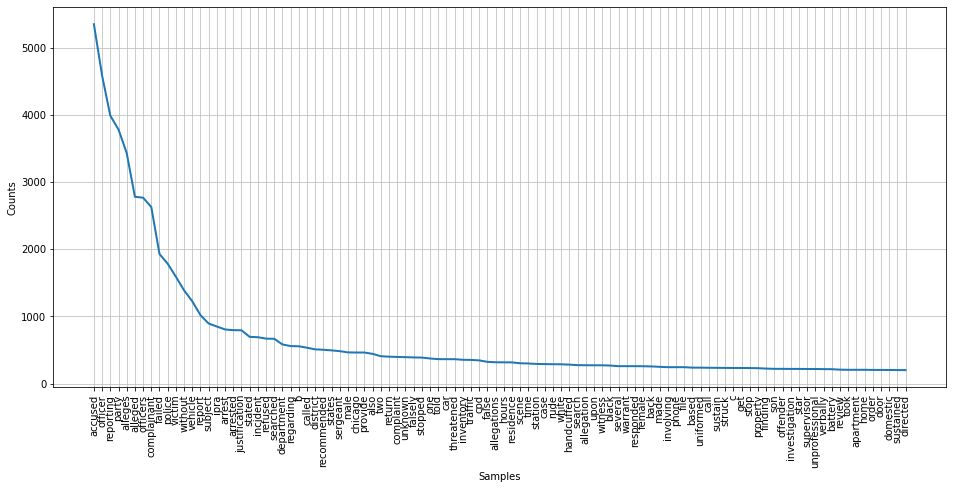

[('accused', 5347),
 ('officer', 4581),
 ('reporting', 3986),
 ('party', 3780),
 ('alleges', 3429),
 ('alleged', 2779),
 ('officers', 2765),
 ('complainant', 2626),
 ('failed', 1927),
 ('police', 1782),
 ('victim', 1589),
 ('without', 1386),
 ('vehicle', 1223),
 ('report', 1017),
 ('subject', 892),
 ('ipra', 848),
 ('arrest', 804),
 ('arrested', 794),
 ('justification', 792),
 ('stated', 694),
 ('incident', 689),
 ('refused', 668),
 ('searched', 665),
 ('department', 581),
 ('regarding', 557),
 ('b', 554),
 ('called', 532),
 ('district', 508),
 ('recommended', 502),
 ('states', 493),
 ('sergeant', 481),
 ('male', 463),
 ('chicago', 461),
 ('provide', 461),
 ('also', 441),
 ('two', 406),
 ('return', 399),
 ('complaint', 395),
 ('unknown', 392),
 ('falsely', 388),
 ('stopped', 386),
 ('one', 372),
 ('told', 363),
 ('car', 362),
 ('threatened', 362),
 ('inventory', 353),
 ('traffic', 351),
 ('cpd', 344),
 ('false', 322),
 ('allegations', 316),
 ('hours', 315),
 ('residence', 314),
 ('scen

In [ ]:
######################
## Remove stopwords ##
######################

# Bigger figure
plt.rcParams["figure.figsize"] = [16,7]

# Check every token in 'tokens_clean' against the NLTK stopword list
# Only keep tokens NOT in the list
tokens_clean = [t for t in tokens_clean if not t in set(stopwords.words('english'))]

# Generate a new frequency distribution plot with the 50 most frequent words remaining after filtering
# This follows the same steps as before: We count the frequency of each token, we generate a plot of the top 50, and then we display them.
frequencies = FreqDist( tokens_clean )

# Make plot with top 50 tokens
black_plot = frequencies.plot( 100 )

# Show the plot
black_plot

# Also print the raw list
frequencies.most_common(100)

In [ ]:
Black_list = []
for i in range(100):
  word = frequencies.most_common(100)[i][0]
  Black_list.append(word)
print(Black_list)

['accused', 'officer', 'reporting', 'party', 'alleges', 'alleged', 'officers', 'complainant', 'failed', 'police', 'victim', 'without', 'vehicle', 'report', 'subject', 'ipra', 'arrest', 'arrested', 'justification', 'stated', 'incident', 'refused', 'searched', 'department', 'regarding', 'b', 'called', 'district', 'recommended', 'states', 'sergeant', 'male', 'chicago', 'provide', 'also', 'two', 'return', 'complaint', 'unknown', 'falsely', 'stopped', 'one', 'told', 'car', 'threatened', 'inventory', 'traffic', 'cpd', 'false', 'allegations', 'hours', 'residence', 'scene', 'time', 'station', 'case', 'rude', 'white', 'handcuffed', 'search', 'allegation', 'upon', 'witness', 'black', 'several', 'warrant', 'responded', 'female', 'back', 'made', 'involving', 'phone', 'file', 'based', 'uniformed', 'call', 'sustain', 'struck', 'c', 'get', 'stop', 'property', 'finding', 'son', 'offender', 'investigation', 'star', 'supervisor', 'unprofessional', 'verbally', 'battery', 'review', 'took', 'apartment', 'h

In [ ]:
print('unique in black:', list(list(set(Black_list)-set(All_list))))
print('unique in all:', list(list(set(All_list)-set(Black_list))))

print('same:' ,list(set(Black_list) - set(list(list(set(Black_list)-set(All_list))))))

unique in black: ['door', 'son', 'uniformed', 'get', 'unprofessional', 'black', 'directed', 'offender', 'took', 'supervisor', 'home', 'female', 'file', 'domestic']
unique in all: ['occurred', 'duty', 'independent', 'complainants', 'authority', 'reports', 'reported', 'abused', 'altercation', 'statements', 'approximately', 'registered', 'number', 'weapon']
same: ['allegations', 'threatened', 'traffic', 'several', 'complaint', 'return', 'arrested', 'cpd', 'ipra', 'battery', 'order', 'investigation', 'department', 'upon', 'phone', 'allegation', 'failed', 'two', 'stop', 'vehicle', 'also', 'review', 'involving', 'made', 'sustain', 'c', 'complainant', 'one', 'reporting', 'false', 'told', 'report', 'back', 'call', 'responded', 'falsely', 'sustained', 'regarding', 'police', 'officer', 'victim', 'finding', 'stated', 'sergeant', 'recommended', 'states', 'white', 'handcuffed', 'accused', 'officers', 'refused', 'arrest', 'unknown', 'without', 'district', 'struck', 'subject', 'alleged', 'verbally', 

## **White race**

In [ ]:
for i in range(len(all_narratives_df)):
  if i == 0:
    white = '0, '
  if all_narratives_df['complainant_race'][i] == "White":
    white = white + all_narratives_df['summary'][i]

tokens = word_tokenize(white)

notalpha = [ token for token in tokens if not token.isalpha() ]
freqs = FreqDist(notalpha)
print( freqs.most_common(100) )

tokens_clean = [ token for token in tokens if token.isalpha() ]

print(tokens_clean)

[(',', 5320), ('.', 2661), ('(', 802), (')', 798), (';', 764), ('#', 532), ('``', 313), ('1', 284), ("''", 252), ("'s", 219), ('?', 207), ('2012', 173), ('2011', 167), ('off-duty', 161), ('on-duty', 158), ('“', 135), (':', 133), ('2009', 121), ('”', 121), ('$', 106), ('2', 90), ('2007', 87), ('2008', 86), ('911', 80), ('2013', 78), ('30', 69), ('P.O', 69), ('-', 64), ('2010', 60), ('&', 58), ('12', 56), ('party/victim', 56), ('‘', 51), ("n't", 49), ('13', 48), ('10', 45), ('17', 44), ('15', 44), ('|', 44), ('20', 41), ('5', 40), ('2014', 40), ('14', 38), ('Mr.', 38), ('21', 35), ('S.', 35), ('6', 32), ('26', 32), ('18', 31), ('M.', 31), ('9', 30), ('and/or', 29), ('3', 29), ('22nd', 29), ('24', 29), ('23', 28), ('member.On', 27), ('2006', 26), ('16', 26), ('8217', 26), ('2015', 26), ('2017', 26), ('29', 25), ('121', 25), ('Complainant/Officer', 24), ('!', 24), ('4', 23), ('on-', 23), ('2300', 23), ('25', 22), ('27', 21), ('off-', 21), ('06', 21), ('28', 21), ("'m", 21), ('_', 21), ('’'

In [ ]:
# Use another list comprehension to save the lowercase version to tokens_clean (overwriting the original)
tokens_clean = [ token.lower() for token in tokens_clean ]

# Print the result
print( tokens_clean )

['on', 'november', 'a', 'complaint', 'was', 'registered', 'with', 'the', 'independent', 'police', 'review', 'authority', 'ipra', 'office', 'of', 'professional', 'standards', 'regarding', 'incidents', 'occurring', 'in', 'the', 'and', 'districts', 'involving', 'two', 'chicago', 'police', 'department', 'members', 'the', 'first', 'accused', 'member', 'while', 'in', 'the', 'district', 'was', 'alleged', 'to', 'have', 'been', 'in', 'possession', 'of', 'an', 'unauthorized', 'firearm', 'that', 'he', 'fired', 'that', 'revolver', 'in', 'single', 'action', 'accidentally', 'discharging', 'the', 'firearm', 'and', 'failed', 'to', 'immediately', 'notify', 'the', 'office', 'of', 'emergency', 'management', 'and', 'communications', 'oemc', 'and', 'the', 'desk', 'sergeant', 'of', 'the', 'district', 'of', 'the', 'firearm', 'discharge', 'left', 'the', 'scene', 'of', 'the', 'firearm', 'discharge', 'and', 'had', 'knowledge', 'of', 'and', 'failed', 'to', 'report', 'the', 'misconduct', 'of', 'a', 'second', 'acc

In [ ]:
# This line specifies the size of the figure as out Jupyter Notebook will print it
import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams["figure.figsize"] = [16,7]

# Calculate the frequency for each token from the book and save it to the variable 'frequencies'
frequencies = FreqDist( tokens_clean )



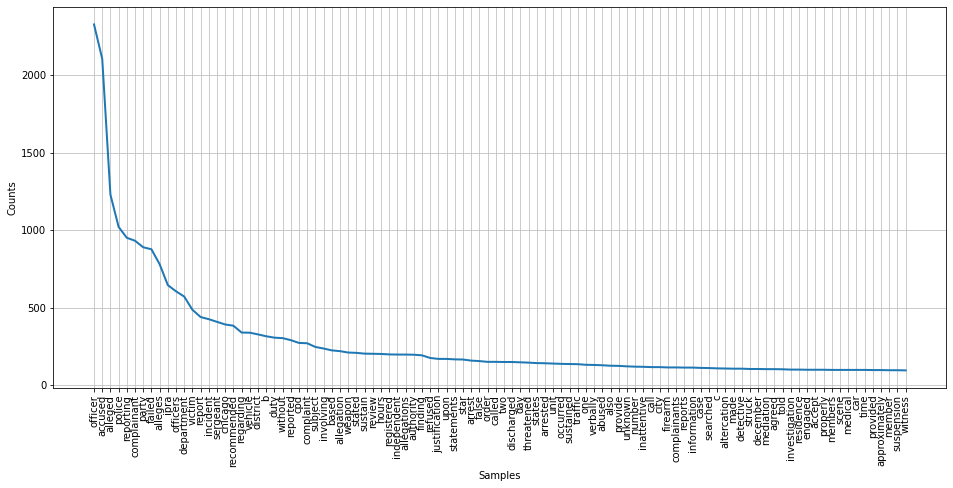

[('officer', 2328),
 ('accused', 2106),
 ('alleged', 1230),
 ('police', 1022),
 ('reporting', 952),
 ('complainant', 933),
 ('party', 891),
 ('failed', 878),
 ('alleges', 782),
 ('ipra', 647),
 ('officers', 607),
 ('department', 573),
 ('victim', 488),
 ('report', 441),
 ('incident', 427),
 ('sergeant', 410),
 ('chicago', 393),
 ('recommended', 385),
 ('regarding', 341),
 ('vehicle', 340),
 ('district', 329),
 ('b', 317),
 ('duty', 308),
 ('without', 305),
 ('reported', 292),
 ('cpd', 274),
 ('complaint', 272),
 ('subject', 248),
 ('involving', 238),
 ('based', 226),
 ('allegation', 221),
 ('weapon', 212),
 ('stated', 210),
 ('sustain', 205),
 ('review', 204),
 ('hours', 203),
 ('registered', 200),
 ('independent', 199),
 ('allegations', 199),
 ('authority', 198),
 ('finding', 194),
 ('refused', 177),
 ('justification', 171),
 ('upon', 171),
 ('statements', 168),
 ('star', 167),
 ('arrest', 160),
 ('false', 157),
 ('order', 152),
 ('called', 152),
 ('two', 151),
 ('discharged', 151),
 

In [ ]:
######################
## Remove stopwords ##
######################

# Bigger figure
plt.rcParams["figure.figsize"] = [16,7]

# Check every token in 'tokens_clean' against the NLTK stopword list
# Only keep tokens NOT in the list
tokens_clean = [t for t in tokens_clean if not t in set(stopwords.words('english'))]

# Generate a new frequency distribution plot with the 50 most frequent words remaining after filtering
# This follows the same steps as before: We count the frequency of each token, we generate a plot of the top 50, and then we display them.
frequencies = FreqDist( tokens_clean )

# Make plot with top 50 tokens
white_plot = frequencies.plot( 100 )

# Show the plot
white_plot

# Also print the raw list
frequencies.most_common(100)

In [ ]:
White_list = []
for i in range(100):
  word = frequencies.most_common(100)[i][0]
  White_list.append(word)
print(White_list)

['officer', 'accused', 'alleged', 'police', 'reporting', 'complainant', 'party', 'failed', 'alleges', 'ipra', 'officers', 'department', 'victim', 'report', 'incident', 'sergeant', 'chicago', 'recommended', 'regarding', 'vehicle', 'district', 'b', 'duty', 'without', 'reported', 'cpd', 'complaint', 'subject', 'involving', 'based', 'allegation', 'weapon', 'stated', 'sustain', 'review', 'hours', 'registered', 'independent', 'allegations', 'authority', 'finding', 'refused', 'justification', 'upon', 'statements', 'star', 'arrest', 'false', 'order', 'called', 'two', 'discharged', 'day', 'threatened', 'states', 'arrested', 'unit', 'occurred', 'sustained', 'traffic', 'one', 'verbally', 'abused', 'also', 'provide', 'unknown', 'number', 'inattentive', 'call', 'city', 'firearm', 'complainants', 'reports', 'information', 'case', 'searched', 'c', 'altercation', 'made', 'detective', 'struck', 'december', 'mediation', 'agreed', 'told', 'investigation', 'residence', 'engaged', 'accept', 'properly', 'me

In [ ]:
print('unique in white:', list(list(set(White_list)-set(All_list))))
print('unique in all:', list(list(set(All_list)-set(White_list))))

print('same:' ,list(set(White_list) - set(list(list(set(White_list)-set(All_list))))))

unique in white: ['day', 'member', 'provided', 'firearm', 'members', 'properly', 'agreed', 'medical', 'engaged', 'accept', 'suspension', 'mediation', 'inattentive', 'discharged', 'unit', 'city', 'detective', 'information', 'december']
unique in all: ['phone', 'responded', 'white', 'several', 'stopped', 'falsely', 'property', 'warrant', 'search', 'handcuffed', 'male', 'stop', 'return', 'rude', 'station', 'inventory', 'apartment', 'battery', 'back']
same: ['allegations', 'duty', 'traffic', 'threatened', 'complaint', 'arrested', 'cpd', 'registered', 'ipra', 'order', 'department', 'upon', 'investigation', 'allegation', 'failed', 'two', 'vehicle', 'also', 'number', 'review', 'involving', 'made', 'sustain', 'c', 'complainant', 'approximately', 'one', 'reporting', 'false', 'told', 'report', 'authority', 'call', 'independent', 'sustained', 'regarding', 'police', 'officer', 'victim', 'finding', 'stated', 'sergeant', 'recommended', 'states', 'occurred', 'accused', 'officers', 'refused', 'abused'

## **Hispanic race**

In [ ]:
for i in range(len(all_narratives_df)):
  if i == 0:
    hispanic = '0, '
  if all_narratives_df['complainant_race'][i] == "Hispanic":
    hispanic = hispanic + all_narratives_df['summary'][i]

tokens = word_tokenize(hispanic)

notalpha = [ token for token in tokens if not token.isalpha() ]
freqs = FreqDist(notalpha)
print( freqs.most_common(100) )

tokens_clean = [ token for token in tokens if token.isalpha() ]

print(tokens_clean)

[(',', 2545), ('.', 1546), (';', 478), ('(', 334), (')', 326), ('?', 219), ('``', 177), ('1', 163), ("''", 147), ('#', 143), ("'s", 118), ('“', 91), ('$', 83), ('off-duty', 65), ('”', 62), (':', 61), ('2009', 60), ('on-duty', 59), ('2011', 56), ('2012', 52), ('911', 49), ('2008', 49), ('2', 43), ('2007', 36), ('|', 33), ('Mr.', 33), ('2013', 31), ('2014', 31), ('3', 30), ('-', 30), ('12', 29), ('and/or', 27), ('&', 27), ('Complainant/Officer', 26), ("n't", 26), ('13', 25), ('U.S.C', 24), ('20', 23), ('2010', 22), ('Ms.', 22), ('10', 21), ('30', 21), ('2300', 21), ('2017', 21), ('‘', 20), ('4', 19), ('22', 19), ("'S", 19), ('S.', 19), ('21345', 19), ('15', 18), ("'re", 18), ('P.O', 18), ('_and', 18), ('M.', 17), ('party/victim', 17), ('27', 16), ('5', 15), ('!', 15), ('14th', 14), ('5101', 14), ('1554', 14), ('2006', 13), ('8th', 13), ('21', 13), ('18', 13), ('f/k/a', 12), ('16', 12), ('26', 12), ('6', 12), ('16th', 11), ('0200', 11), ('8217', 11), ('23', 10), ('17', 10), ("'", 10), ('3

In [ ]:
# Use another list comprehension to save the lowercase version to tokens_clean (overwriting the original)
tokens_clean = [ token.lower() for token in tokens_clean ]

# Print the result
print( tokens_clean )

# This line specifies the size of the figure as out Jupyter Notebook will print it
import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams["figure.figsize"] = [16,7]

# Calculate the frequency for each token from the book and save it to the variable 'frequencies'
frequencies = FreqDist( tokens_clean )

['on', 'october', 'a', 'complaint', 'was', 'registered', 'with', 'the', 'independent', 'police', 'review', 'authority', 'ipra', 'the', 'office', 'of', 'professional', 'standards', 'regarding', 'an', 'incident', 'occurring', 'in', 'the', 'district', 'on', 'october', 'involving', 'two', 'chicago', 'police', 'department', 'cpd', 'officers', 'officer', 'a', 'and', 'probationary', 'officer', 'b', 'both', 'of', 'whom', 'were', 'off', 'duty', 'it', 'was', 'alleged', 'that', 'officer', 'a', 'directed', 'profanity', 'at', 'the', 'complainant', 'engaged', 'in', 'an', 'unjustified', 'physical', 'altercation', 'with', 'the', 'complainant', 'failed', 'to', 'complete', 'a', 'tactical', 'response', 'report', 'trr', 'for', 'her', 'contact', 'with', 'the', 'complainant', 'and', 'provided', 'a', 'false', 'statement', 'to', 'ipra', 'in', 'addition', 'it', 'was', 'alleged', 'that', 'probationary', 'officer', 'b', 'grabbed', 'the', 'complainant', 'by', 'her', 'hair', 'and', 'punched', 'the', 'complainant',

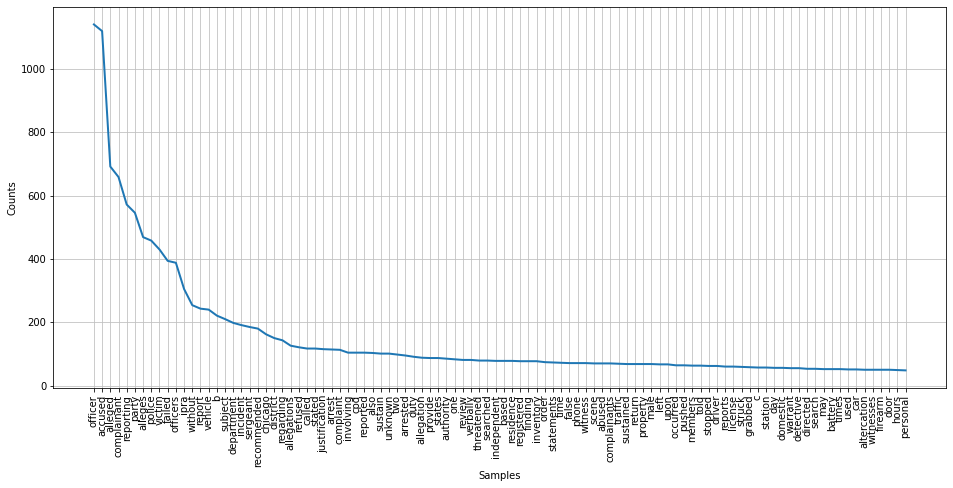

[('officer', 1141),
 ('accused', 1120),
 ('alleged', 692),
 ('complainant', 659),
 ('reporting', 572),
 ('party', 546),
 ('alleges', 469),
 ('police', 458),
 ('victim', 430),
 ('failed', 394),
 ('officers', 388),
 ('ipra', 305),
 ('without', 254),
 ('report', 243),
 ('vehicle', 240),
 ('b', 221),
 ('subject', 210),
 ('department', 198),
 ('incident', 191),
 ('sergeant', 185),
 ('recommended', 180),
 ('chicago', 162),
 ('district', 150),
 ('regarding', 143),
 ('allegations', 126),
 ('refused', 121),
 ('called', 117),
 ('stated', 117),
 ('justification', 115),
 ('arrest', 114),
 ('complaint', 113),
 ('involving', 104),
 ('cpd', 104),
 ('reported', 104),
 ('also', 103),
 ('sustain', 101),
 ('unknown', 101),
 ('two', 98),
 ('arrested', 95),
 ('duty', 91),
 ('allegation', 88),
 ('provide', 87),
 ('states', 87),
 ('authority', 85),
 ('one', 83),
 ('review', 81),
 ('verbally', 81),
 ('threatened', 79),
 ('searched', 79),
 ('independent', 78),
 ('based', 78),
 ('residence', 78),
 ('registered'

In [ ]:
######################
## Remove stopwords ##
######################

# Bigger figure
plt.rcParams["figure.figsize"] = [16,7]

# Check every token in 'tokens_clean' against the NLTK stopword list
# Only keep tokens NOT in the list
tokens_clean = [t for t in tokens_clean if not t in set(stopwords.words('english'))]

# Generate a new frequency distribution plot with the 50 most frequent words remaining after filtering
# This follows the same steps as before: We count the frequency of each token, we generate a plot of the top 50, and then we display them.
frequencies = FreqDist( tokens_clean )

# Make plot with top 50 tokens
hispanic_plot = frequencies.plot( 100 )

# Show the plot
hispanic_plot

# Also print the raw list
frequencies.most_common(100)

In [ ]:
Hispanic_list = []
for i in range(100):
  word = frequencies.most_common(100)[i][0]
  Hispanic_list.append(word)
print(Hispanic_list)

['officer', 'accused', 'alleged', 'complainant', 'reporting', 'party', 'alleges', 'police', 'victim', 'failed', 'officers', 'ipra', 'without', 'report', 'vehicle', 'b', 'subject', 'department', 'incident', 'sergeant', 'recommended', 'chicago', 'district', 'regarding', 'allegations', 'refused', 'called', 'stated', 'justification', 'arrest', 'complaint', 'involving', 'cpd', 'reported', 'also', 'sustain', 'unknown', 'two', 'arrested', 'duty', 'allegation', 'provide', 'states', 'authority', 'one', 'review', 'verbally', 'threatened', 'searched', 'independent', 'based', 'residence', 'registered', 'finding', 'inventory', 'order', 'statements', 'time', 'false', 'phone', 'witness', 'scene', 'abused', 'complainants', 'traffic', 'sustained', 'return', 'property', 'male', 'left', 'upon', 'occurred', 'pushed', 'members', 'told', 'stopped', 'driver', 'reports', 'license', 'struck', 'grabbed', 'c', 'station', 'day', 'domestic', 'warrant', 'detective', 'directed', 'search', 'may', 'battery', 'times', 

In [ ]:
print('unique in Hispanic:', list(list(set(Hispanic_list)-set(All_list))))
print('unique in all:', list(list(set(All_list)-set(Hispanic_list))))

print('same:' ,list(set(Hispanic_list) - set(list(list(set(Hispanic_list)-set(All_list))))))

unique in Hispanic: ['day', 'door', 'used', 'license', 'times', 'left', 'firearm', 'members', 'witnesses', 'driver', 'may', 'personal', 'grabbed', 'pushed', 'detective', 'directed', 'domestic']
unique in all: ['investigation', 'apartment', 'white', 'several', 'falsely', 'star', 'weapon', 'handcuffed', 'made', 'stop', 'case', 'rude', 'approximately', 'number', 'call', 'responded', 'back']
same: ['allegations', 'duty', 'traffic', 'threatened', 'complaint', 'return', 'arrested', 'cpd', 'registered', 'ipra', 'battery', 'order', 'department', 'upon', 'phone', 'allegation', 'failed', 'two', 'vehicle', 'also', 'review', 'involving', 'sustain', 'c', 'complainant', 'one', 'reporting', 'false', 'told', 'report', 'authority', 'independent', 'sustained', 'regarding', 'police', 'officer', 'victim', 'finding', 'stated', 'sergeant', 'recommended', 'states', 'occurred', 'accused', 'officers', 'refused', 'abused', 'arrest', 'unknown', 'without', 'statements', 'struck', 'district', 'subject', 'alleged',

## **Asian/Pacific Islander race**

In [ ]:


for i in range(len(all_narratives_df)):
  if i == 0:
    asian = '0, '
  if all_narratives_df['complainant_race'][i] == "Asian/Pacific Islander":
    asian = asian + all_narratives_df['summary'][i]

tokens = word_tokenize(asian)

notalpha = [ token for token in tokens if not token.isalpha() ]
freqs = FreqDist(notalpha)
print( freqs.most_common(100) )

tokens_clean = [ token for token in tokens if token.isalpha() ]

print(tokens_clean)

[(',', 181), ('.', 114), (';', 21), ('``', 20), (')', 19), ('#', 19), ('(', 17), ("''", 14), ('1', 9), ('2007', 8), ("'s", 8), ('28', 6), (':', 6), ('2', 6), ('2625', 5), ('29', 4), ('”', 4), ('party/victim', 4), ('&', 4), ('$', 4), ('off-duty', 3), ('10', 3), ('2008', 3), ("n't", 3), ('911', 3), ('2012', 3), ('Complainant/Officer', 3), ('2015', 3), ('3', 3), ('2018', 3), ('20', 2), ('on-duty', 2), ('5', 2), ('|', 2), ('?', 2), ('her.The', 2), ('report.The', 2), ('31', 2), ('7270', 2), ('008', 2), ('4', 2), ('8220', 2), ('8221', 2), ('U.S.C', 2), ('015', 2), ('2017', 2), ('24th', 2), ('0', 1), ('12th', 1), ('member.On', 1), ('B.', 1), ('investigation.On', 1), ('21', 1), ('08', 1), ('17th', 1), ('17', 1), ('18', 1), ('review.The', 1), ('-', 1), ('next.The', 1), ('’', 1), ('duty-Failed', 1), ('1049794The', 1), ('“', 1), ('assistance.The', 1), ('3-', 1), ('1-1', 1), ('1o', 1), ('party.The', 1), ('OFFENDER.The', 1), ('assistance.knocked', 1), ('weapons.THE', 1), ("N'T", 1), ('BURGLARY.THE'

In [ ]:
# Use another list comprehension to save the lowercase version to tokens_clean (overwriting the original)
tokens_clean = [ token.lower() for token in tokens_clean ]

# Print the result
print( tokens_clean )

# This line specifies the size of the figure as out Jupyter Notebook will print it
import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams["figure.figsize"] = [16,7]

# Calculate the frequency for each token from the book and save it to the variable 'frequencies'
frequencies = FreqDist( tokens_clean )

['on', 'december', 'a', 'complaint', 'was', 'registered', 'with', 'the', 'independent', 'police', 'review', 'authority', 'ipra', 'regarding', 'incidents', 'occurring', 'in', 'the', 'district', 'on', 'december', 'and', 'december', 'it', 'was', 'alleged', 'that', 'on', 'december', 'during', 'a', 'domestic', 'altercation', 'with', 'his', 'wife', 'an', 'chicago', 'police', 'department', 'cpd', 'officer', 'verbally', 'abused', 'her', 'threatened', 'her', 'was', 'intoxicated', 'operated', 'a', 'motor', 'vehicle', 'under', 'the', 'influence', 'of', 'alcohol', 'and', 'failed', 'to', 'properly', 'secure', 'his', 'firearms', 'in', 'addition', 'it', 'was', 'alleged', 'that', 'on', 'december', 'the', 'officer', 'while', 'off', 'duty', 'and', 'during', 'a', 'domestic', 'altercation', 'with', 'his', 'wife', 'verbally', 'abused', 'and', 'threatened', 'her', 'it', 'is', 'further', 'alleged', 'that', 'the', 'officer', 'failed', 'to', 'properly', 'secure', 'his', 'firearms', 'on', 'numerous', 'dates', '

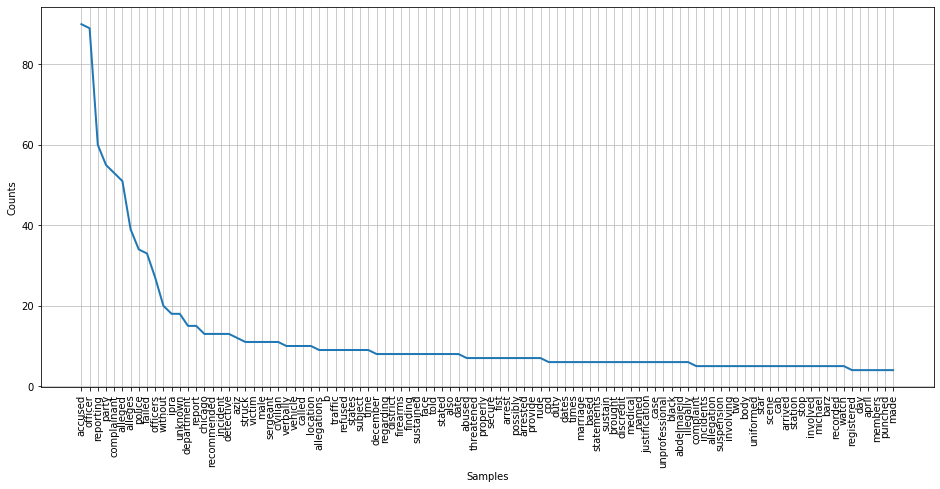

[('accused', 90),
 ('officer', 89),
 ('reporting', 60),
 ('party', 55),
 ('complainant', 53),
 ('alleged', 51),
 ('alleges', 39),
 ('police', 34),
 ('failed', 33),
 ('officers', 27),
 ('without', 20),
 ('ipra', 18),
 ('unknown', 18),
 ('department', 15),
 ('report', 15),
 ('chicago', 13),
 ('recommended', 13),
 ('incident', 13),
 ('detective', 13),
 ('aziz', 12),
 ('struck', 11),
 ('victim', 11),
 ('male', 11),
 ('sergeant', 11),
 ('civilian', 11),
 ('verbally', 10),
 ('vehicle', 10),
 ('called', 10),
 ('location', 10),
 ('allegations', 9),
 ('b', 9),
 ('traffic', 9),
 ('refused', 9),
 ('states', 9),
 ('subject', 9),
 ('time', 9),
 ('december', 8),
 ('regarding', 8),
 ('district', 8),
 ('firearms', 8),
 ('finding', 8),
 ('sustained', 8),
 ('face', 8),
 ('told', 8),
 ('stated', 8),
 ('also', 8),
 ('date', 8),
 ('abused', 7),
 ('threatened', 7),
 ('properly', 7),
 ('secure', 7),
 ('fist', 7),
 ('arrest', 7),
 ('possibly', 7),
 ('arrested', 7),
 ('provide', 7),
 ('rude', 7),
 ('cpd', 6),


In [ ]:
######################
## Remove stopwords ##
######################

# Bigger figure
plt.rcParams["figure.figsize"] = [16,7]

# Check every token in 'tokens_clean' against the NLTK stopword list
# Only keep tokens NOT in the list
tokens_clean = [t for t in tokens_clean if not t in set(stopwords.words('english'))]

# Generate a new frequency distribution plot with the 50 most frequent words remaining after filtering
# This follows the same steps as before: We count the frequency of each token, we generate a plot of the top 50, and then we display them.
frequencies = FreqDist( tokens_clean )

# Make plot with top 50 tokens
asian_plot = frequencies.plot( 100 )

# Show the plot
asian_plot

# Also print the raw list
frequencies.most_common(100)

In [ ]:
Asian_list = []
for i in range(100):
  word = frequencies.most_common(100)[i][0]
  Asian_list.append(word)
print(Asian_list)

['accused', 'officer', 'reporting', 'party', 'complainant', 'alleged', 'alleges', 'police', 'failed', 'officers', 'without', 'ipra', 'unknown', 'department', 'report', 'chicago', 'recommended', 'incident', 'detective', 'aziz', 'struck', 'victim', 'male', 'sergeant', 'civilian', 'verbally', 'vehicle', 'called', 'location', 'allegations', 'b', 'traffic', 'refused', 'states', 'subject', 'time', 'december', 'regarding', 'district', 'firearms', 'finding', 'sustained', 'face', 'told', 'stated', 'also', 'date', 'abused', 'threatened', 'properly', 'secure', 'fist', 'arrest', 'possibly', 'arrested', 'provide', 'rude', 'cpd', 'duty', 'dates', 'times', 'marriage', 'based', 'statements', 'sustain', 'brought', 'discredit', 'medical', 'named', 'justification', 'case', 'unprofessional', 'black', 'abdelmajeid', 'illegally', 'complaint', 'incidents', 'allegation', 'suspension', 'involving', 'two', 'body', 'uniformed', 'star', 'scene', 'cab', 'arrived', 'station', 'stop', 'involved', 'michael', 'barz', 

In [ ]:
print('unique in Asian:', list(list(set(Asian_list)-set(All_list))))
print('unique in all:', list(list(set(All_list)-set(Asian_list))))

print('same:' ,list(set(Asian_list) - set(list(list(set(Asian_list)-set(All_list))))))

unique in Asian: ['properly', 'named', 'april', 'december', 'members', 'location', 'abdelmajeid', 'incidents', 'cab', 'date', 'brought', 'day', 'involved', 'discredit', 'barz', 'uniformed', 'aziz', 'detective', 'body', 'secure', 'arrived', 'punched', 'suspension', 'marriage', 'black', 'firearms', 'face', 'possibly', 'civilian', 'times', 'dates', 'unprofessional', 'medical', 'recorded', 'fist', 'illegally', 'michael', 'watch']
unique in all: ['occurred', 'white', 'several', 'handcuffed', 'return', 'battery', 'order', 'investigation', 'phone', 'upon', 'weapon', 'property', 'stopped', 'altercation', 'inventory', 'apartment', 'number', 'review', 'reports', 'hours', 'residence', 'searched', 'c', 'one', 'reported', 'approximately', 'search', 'false', 'authority', 'call', 'responded', 'back', 'car', 'independent', 'falsely', 'complainants', 'warrant', 'witness']
same: ['allegations', 'duty', 'traffic', 'threatened', 'complaint', 'accused', 'officers', 'refused', 'abused', 'arrest', 'unknown',

## **Native American/Alaskan Native**

In [ ]:


for i in range(len(all_narratives_df)):
  if i == 0:
    alask = '0, '
  if all_narratives_df['complainant_race'][i] == "Native American/Alaskan Native":
    alask = alask + all_narratives_df['summary'][i]

tokens = word_tokenize(alask)

notalpha = [ token for token in tokens if not token.isalpha() ]
freqs = FreqDist(notalpha)
print( freqs.most_common(100) )

tokens_clean = [ token for token in tokens if token.isalpha() ]

print(tokens_clean)

[(',', 33), ('.', 26), ('``', 8), (';', 7), ("''", 5), ('”', 4), (':', 3), ('30', 3), ('2012', 3), ("'s", 3), ('party/victim', 3), ('?', 2), ('$', 2), ('1200.00', 2), ('1100', 2), ('(', 2), (')', 2), ('“', 2), ('party/third', 2), ('‘', 2), ('0', 1), ('narcotics.The', 1), ('#', 1), ('motherfucker.', 1), ("'", 1), ('<', 1), ('/aiant', 1), ('1o', 1), ("'1oday", 1), ("I'l", 1), ('them.', 1), ('him.The', 1), ('it.The', 1), ('15', 1), ('location.The', 1), ("'ll", 1), ("n't", 1), ('1900', 1), ('03', 1), ('2013.It', 1), ('*', 1), ('—', 1), ('leave.The', 1), ('311', 1), ('liar.', 1), ('belongings.It', 1)]
['The', 'complainant', 'alleges', 'that', 'the', 'accused', 'officer', 'arrested', 'her', 'without', 'justification', 'The', 'complainant', 'alleges', 'that', 'the', 'accused', 'officer', 'asked', 'her', 'Where', 'is', 'it', 'at', 'possibly', 'pertaining', 'to', 'who', 'she', 'knew', 'that', 'sold', 'drugs', 'The', 'complainant', 'alleges', 'that', 'once', 'she', 'arrived', 'at', 'the', 'Distr

In [ ]:
# Use another list comprehension to save the lowercase version to tokens_clean (overwriting the original)
tokens_clean = [ token.lower() for token in tokens_clean ]

# Print the result
print( tokens_clean )

# This line specifies the size of the figure as out Jupyter Notebook will print it
import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams["figure.figsize"] = [16,7]

# Calculate the frequency for each token from the book and save it to the variable 'frequencies'
frequencies = FreqDist( tokens_clean )

['the', 'complainant', 'alleges', 'that', 'the', 'accused', 'officer', 'arrested', 'her', 'without', 'justification', 'the', 'complainant', 'alleges', 'that', 'the', 'accused', 'officer', 'asked', 'her', 'where', 'is', 'it', 'at', 'possibly', 'pertaining', 'to', 'who', 'she', 'knew', 'that', 'sold', 'drugs', 'the', 'complainant', 'alleges', 'that', 'once', 'she', 'arrived', 'at', 'the', 'district', 'station', 'the', 'accused', 'officer', 'implied', 'he', 'could', 'make', 'it', 'easy', 'for', 'her', 'and', 'possibly', 'return', 'her', 'if', 'she', 'knew', 'who', 'was', 'selling', 'narcotics', 'the', 'complainant', 'alleges', 'that', 'the', 'accused', 'officer', 'arrested', 'her', 'without', 'justification', 'the', 'complainant', 'alleges', 'that', 'the', 'accused', 'officer', 'asked', 'her', 'where', 'is', 'it', 'at', 'possibly', 'pertaining', 'to', 'who', 'she', 'knew', 'that', 'sold', 'drugs', 'the', 'complainant', 'alleges', 'that', 'once', 'she', 'arrived', 'at', 'the', 'district', 

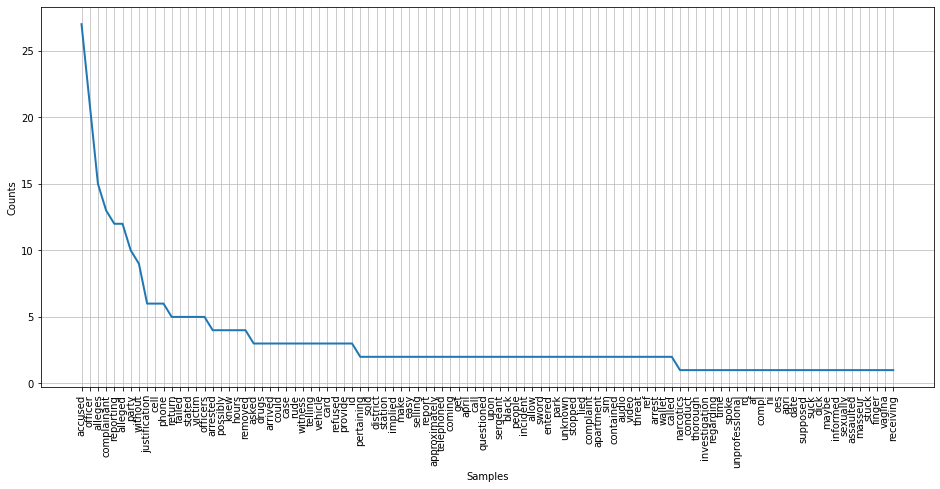

[('accused', 27),
 ('officer', 21),
 ('alleges', 15),
 ('complainant', 13),
 ('reporting', 12),
 ('alleged', 12),
 ('party', 10),
 ('without', 9),
 ('justification', 6),
 ('cell', 6),
 ('phone', 6),
 ('return', 5),
 ('failed', 5),
 ('stated', 5),
 ('victim', 5),
 ('officers', 5),
 ('arrested', 4),
 ('possibly', 4),
 ('knew', 4),
 ('hours', 4),
 ('removed', 4),
 ('asked', 3),
 ('drugs', 3),
 ('arrived', 3),
 ('could', 3),
 ('case', 3),
 ('rude', 3),
 ('witness', 3),
 ('telling', 3),
 ('vehicle', 3),
 ('card', 3),
 ('refused', 3),
 ('provide', 3),
 ('id', 3),
 ('pertaining', 2),
 ('sold', 2),
 ('district', 2),
 ('station', 2),
 ('implied', 2),
 ('make', 2),
 ('easy', 2),
 ('selling', 2),
 ('report', 2),
 ('approximately', 2),
 ('telephoned', 2),
 ('coming', 2),
 ('get', 2),
 ('april', 2),
 ('call', 2),
 ('questioned', 2),
 ('upon', 2),
 ('sergeant', 2),
 ('black', 2),
 ('people', 2),
 ('incident', 2),
 ('allow', 2),
 ('sword', 2),
 ('entered', 2),
 ('park', 2),
 ('unknown', 2),
 ('stoppe

In [ ]:
######################
## Remove stopwords ##
######################

# Bigger figure
plt.rcParams["figure.figsize"] = [16,7]

# Check every token in 'tokens_clean' against the NLTK stopword list
# Only keep tokens NOT in the list
tokens_clean = [t for t in tokens_clean if not t in set(stopwords.words('english'))]

# Generate a new frequency distribution plot with the 50 most frequent words remaining after filtering
# This follows the same steps as before: We count the frequency of each token, we generate a plot of the top 50, and then we display them.
frequencies = FreqDist( tokens_clean )

# Make plot with top 50 tokens
asian_plot = frequencies.plot( 100 )

# Show the plot
asian_plot

# Also print the raw list
frequencies.most_common(100)

In [ ]:
Alask_list = []
for i in range(100):
  word = frequencies.most_common(100)[i][0]
  Alask_list.append(word)
print(Alask_list)

['accused', 'officer', 'alleges', 'complainant', 'reporting', 'alleged', 'party', 'without', 'justification', 'cell', 'phone', 'return', 'failed', 'stated', 'victim', 'officers', 'arrested', 'possibly', 'knew', 'hours', 'removed', 'asked', 'drugs', 'arrived', 'could', 'case', 'rude', 'witness', 'telling', 'vehicle', 'card', 'refused', 'provide', 'id', 'pertaining', 'sold', 'district', 'station', 'implied', 'make', 'easy', 'selling', 'report', 'approximately', 'telephoned', 'coming', 'get', 'april', 'call', 'questioned', 'upon', 'sergeant', 'black', 'people', 'incident', 'allow', 'sword', 'entered', 'park', 'unknown', 'stopped', 'lied', 'complaint', 'apartment', 'sim', 'contained', 'audio', 'video', 'threat', 'ref', 'arrest', 'wallet', 'called', 'narcotics', 'conduct', 'thorough', 'investigation', 'regarding', 'time', 'spoke', 'unprofessional', 'rd', 'af', 'compl', 'ni', 'oes', 'apri', 'date', 'supposed', 'suck', 'dick', 'maybe', 'informed', 'sexually', 'assaulted', 'masseur', 'stuck', 

In [ ]:
print('unique in Alask:', list(list(set(Alask_list)-set(All_list))))
print('unique in all:', list(list(set(All_list)-set(Alask_list))))

print('same:' ,list(set(Alask_list) - set(list(list(set(Alask_list)-set(All_list))))))

unique in Alask: ['selling', 'drugs', 'card', 'conduct', 'wallet', 'assaulted', 'could', 'audio', 'finger', 'april', 'supposed', 'entered', 'maybe', 'lied', 'dick', 'allow', 'sword', 'ni', 'make', 'rd', 'date', 'oes', 'thorough', 'af', 'suck', 'sexually', 'ref', 'questioned', 'compl', 'people', 'coming', 'arrived', 'narcotics', 'implied', 'park', 'cell', 'black', 'stuck', 'informed', 'get', 'possibly', 'telephoned', 'video', 'easy', 'id', 'masseur', 'threat', 'removed', 'unprofessional', 'sim', 'telling', 'spoke', 'sold', 'vagina', 'receiving', 'apri', 'asked', 'contained', 'pertaining', 'knew']
unique in all: ['allegations', 'duty', 'traffic', 'several', 'threatened', 'occurred', 'white', 'handcuffed', 'abused', 'statements', 'cpd', 'registered', 'ipra', 'battery', 'subject', 'order', 'department', 'verbally', 'struck', 'allegation', 'chicago', 'weapon', 'two', 'property', 'stop', 'altercation', 'b', 'also', 'inventory', 'number', 'review', 'scene', 'involving', 'star', 'reports', 'ma

## **Compare five races together**

In [1]:
# same words in all lists
set.intersection(*[set(list) for list in [Black_list, White_list, Hispanic_list, Asian_list, Alask_list]])